<a href="https://colab.research.google.com/github/Graham1212/Econ-323-Final-Project-Goodreads-Data-Analysis/blob/main/GoodreadsData_FinalProject_Graham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goodreads Data Analysis
ECON 323 Final Project 


Goodreads is a popular website for rating and reviewing books and it also used as a reference for many readers when trying to decide on a new book to read. In addition to simply title and author, the site collects quantitative information about each books as well including its average rating, length, and total number of reviews received. This project will use this data from Goodreads and create visualizations to see if there are any relationships between the variables. Some initial questions of interest that this project will attempt to answer are:

1. Do longer books receive different ratings than shorter books?
2. Are books with more reviews also higher rated?

Regressions will also be run to determine whether any of the variables can predict its average rating. Finally, a suggestion tool will be created to give readers an idea of what to read next, based on adjustable criteria.

Data for this project was obtain from a freely available dataset on Kaggle:https://www.kaggle.com/jealousleopard/goodreadsbooks, which was compiled from the Goodreads API. 

This project can also be found on github: https://github.com/Graham1212/Econ-323-Final-Project-Goodreads-Data-Analysis/blob/main/GoodreadsData_FinalProject_Graham.ipynb

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from wordcloud import WordCloud

# Obtain and clean data

In [2]:
url = "https://raw.githubusercontent.com/Graham1212/Econ-323-Final-Project-Goodreads-Data-Analysis/main/books.csv"
books = pd.read_csv(url)

In [3]:
books.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9.780440e+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9.780440e+12,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9.780440e+12,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.780440e+12,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9.780440e+12,eng,2690,41428,164,9/13/2004,Scholastic


In [4]:
books.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [5]:
books.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11127.000000,11127.000000,1.112700e+04,11127.000000,1.112700e+04,11127.000000
mean,21310.938887,3.933631,9.759888e+12,336.376921,1.793641e+04,541.854498
std,13093.358023,0.352445,4.428964e+11,241.127305,1.124794e+05,2576.176608
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10287.000000,3.770000,9.780350e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780590e+12,299.000000,7.450000e+02,46.000000
75%,32104.500000,4.135000,9.780870e+12,416.000000,4.993500e+03,237.500000
max,45641.000000,5.000000,9.790010e+12,6576.000000,4.597666e+06,94265.000000


In [6]:
books.describe(include=['O'])

,title,authors,isbn,language_code,publication_date,publisher
count,11127,11127,11127,11127,11127,11127
unique,10352,6643,11127,27,3679,2292
top,The Brothers Karamazov,P.G. Wodehouse,013187165X,eng,10/1/2005,Vintage
freq,9,40,1,8911,56,318


In [7]:
# Clean data, drop columns that are not needed
books = books.rename(columns={"  num_pages":"num_pages"})
books2 = books.drop(['isbn','isbn13'], axis=1)


# Visualizations

In this first section, we will see several visualizations of variables in the dataset. We will look at two categories: book ratings and number of published books, and each category will be analyzed in multiple ways.

### Ratings

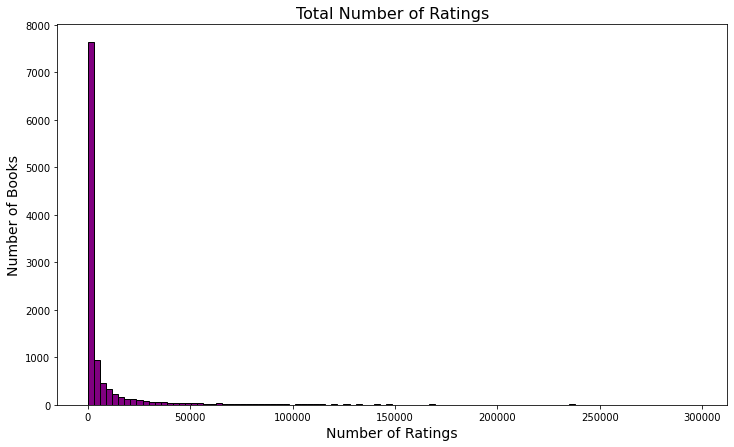

In [8]:
# Filter books to only include up to the 99th percentile in terms of number of ratings, to remove outliers
ratings_99 = books2['ratings_count'].quantile(.99)
ratings = books2.ratings_count.loc[books2.ratings_count < ratings_99]

plt.figure(figsize=(12,7))
plt.hist(ratings, bins = 100, edgecolor = 'black', color = 'purple')
plt.title('Total Number of Ratings', fontsize = 16)
plt.ylabel('Number of Books', fontsize=14)
plt.xlabel('Number of Ratings', fontsize = 14)
plt.show()

We see from this first graph that the overwhelming majority of books have very few or zero ratings, with a small amount of books having a very large number of ratings.

In [9]:
#Convert date variable to datetime type, get the decade, and create a new decade variable for grouping needs in future parts

from datetime import datetime
books2['publication_date'] = pd.to_datetime(books2['publication_date'], format='%m/%d/%Y', errors='coerce')
books2['year'] = books2['publication_date'].dt.year

def getDecade (y):
    if y >= 2020:
        out = 2020
    elif (y >= 2010) & (y < 2020):
        out = 2010
    elif (y >= 2000) & (y < 2010):
        out = 2000
    elif (y >= 1990) & (y < 2000):
        out = 1990
    elif (y >= 1980) & (y < 1990):
        out = 1980
    elif (y >= 1970) & (y < 1980):
        out = 1970
    elif (y >= 1960) & (y < 1970):
        out = 1960
    elif (y >= 1950) & (y < 1960):
        out = 1950
    elif (y >= 1940) & (y < 1950):
        out = 1940
    elif (y >= 1930) & (y < 1940):
        out = 1930
    elif (y >= 1920) & (y < 1930):
        out = 1920
    elif (y >= 1910) & (y < 1920):
        out = 1910
    else:
        out = 1900
    return out

books2['decade'] = books2['year'].apply(getDecade)

In [10]:
# Group data by various categories for future plotting

books_years = books2.groupby('year')
books_decades = books2.groupby('decade')
books_authors = books2.groupby('authors')
books_publishers = books2.groupby('publisher')

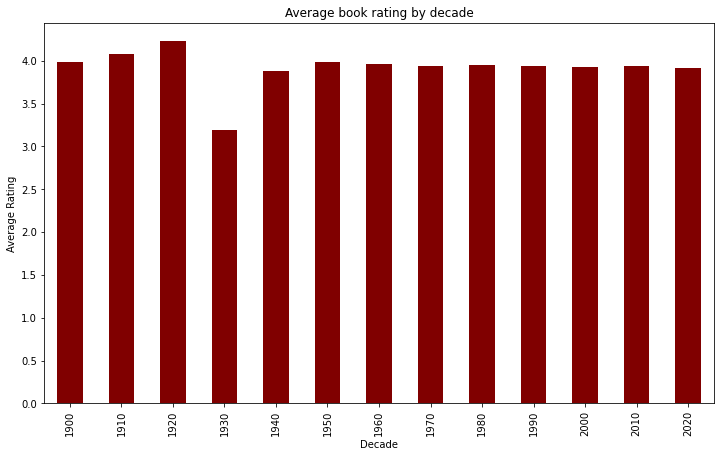

In [11]:
books_decades['average_rating'].mean().plot.bar(color = 'maroon', figsize = (12,7), title = 'Average book rating by decade', xlabel = 'Decade', ylabel = 'Average Rating')

From this graph, we see that the average rating did not change much over time, remaining remarkably consistent across the decades.

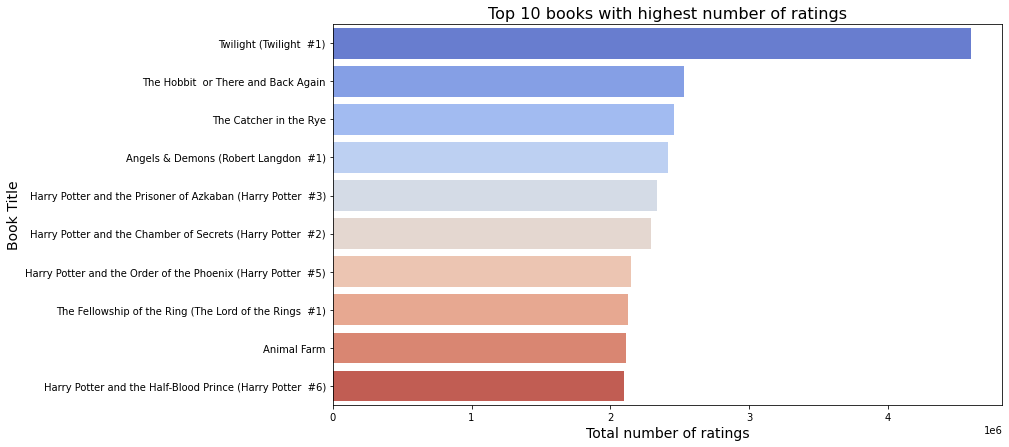

In [12]:
import warnings
warnings.filterwarnings('ignore')

# Filter books to find those with the highest number of ratings
most_rated_books = books2.sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(12,7))
ax = sns.barplot(most_rated_books['ratings_count'], most_rated_books.index, palette='coolwarm')
ax.set_title("Top 10 books with highest number of ratings", fontsize = 16)
ax.set_xlabel("Total number of ratings", fontsize = 14)
ax.set_ylabel("Book Title", fontsize = 14)
plt.show()


This graph shows the 10 books with the highest number of ratings. Of interest here is that the book with the highest number of ratings (Twilight) has almost double the number of ratings as the second highest (The Hobbit).

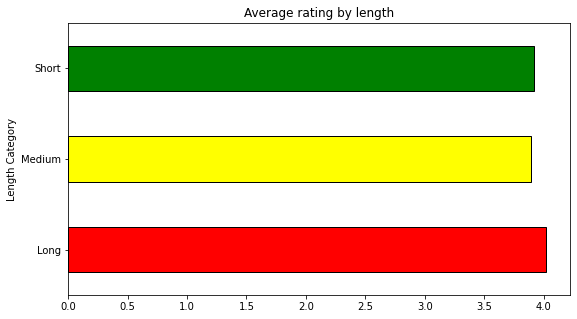

In [13]:
# Find interquartile range of the number of pages of the books in the sample, and use this to classify books into categories based on length
# Short books are those below the 25th percentile, medium books are between the 25th and 75th percentile, and long books are above the 75th percentile

Q1 = books2['num_pages'].quantile(.25)
Q3 = books2['num_pages'].quantile(.75)

def lengthclass (s):
    if s > Q3:
        out = "Long"
    elif (s > Q1) & (s <= Q3):
        out = "Medium"
    else:
        out = "Short"
    return out

books2['length_bins'] = books2['num_pages'].apply(lengthclass)
colors = ['red', 'yellow', 'green']
books2.groupby('length_bins').average_rating.mean().plot.barh(color=colors, figsize=(9,5), edgecolor = 'black', xlabel = 'Length Category', ylabel = 'Average Rating', title = 'Average rating by length')

We see here that book length doesn't appear to have an impact on average rating, at least when classified into length categories. We will return to the question of the effect of book length on average rating in the Correlation section.

### Published Books

Now, we will analyze the data in a different way by looking at the total number of books published. We will look at it by year, author, and publisher. This will identify when the majority of the books in the dataset were published. We will also be able to see which authors and publishers are the most prolific, at least in terms of quantity of content.

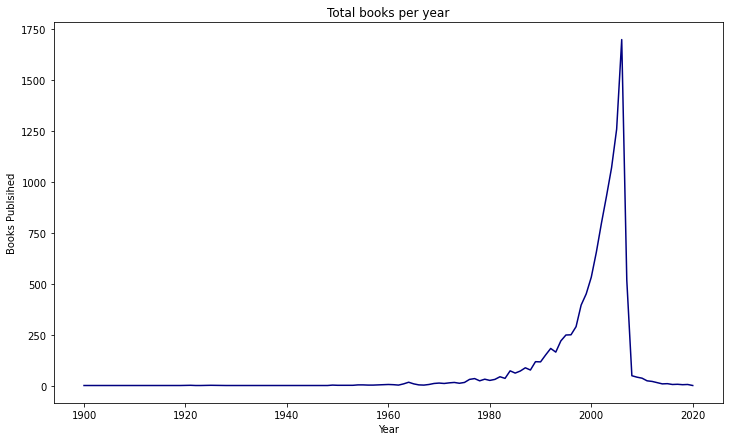

In [14]:
books_years["bookID"].count().plot.line(color='navy', figsize = (12,7),title = 'Total books per year', xlabel = 'Year', ylabel = 'Books Publsihed')

This graph show a large number of books in the dataset were publsihed between 2000 and 2010.

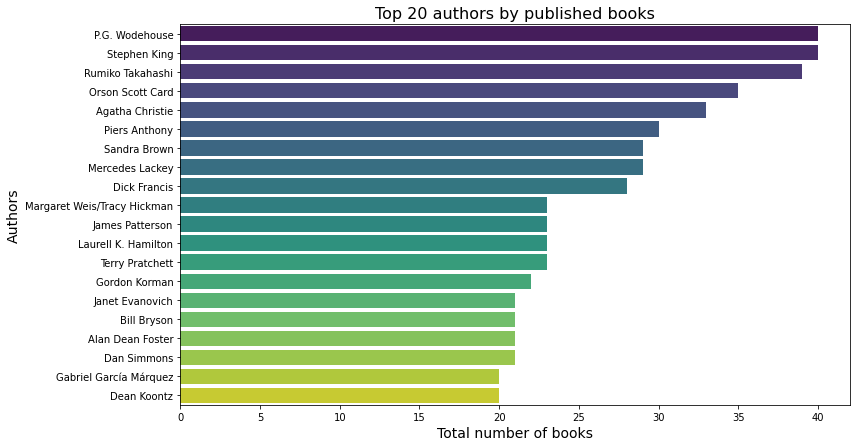

In [15]:

# Use the grouping by author to find authors with the largest number of published books
most_authors = books_authors['title'].count().reset_index().sort_values('title', ascending=False).head(20).set_index('authors')
plt.figure(figsize=(12,7))
ax = sns.barplot(most_authors['title'], most_authors.index, palette='viridis')
ax.set_title("Top 20 authors by published books", fontsize = 16)
ax.set_xlabel("Total number of books", fontsize = 14)
ax.set_ylabel("Authors", fontsize = 14)
plt.show()

P.G. Wodehouse and Stephen were tied for the largest number of books published, both with 40. 

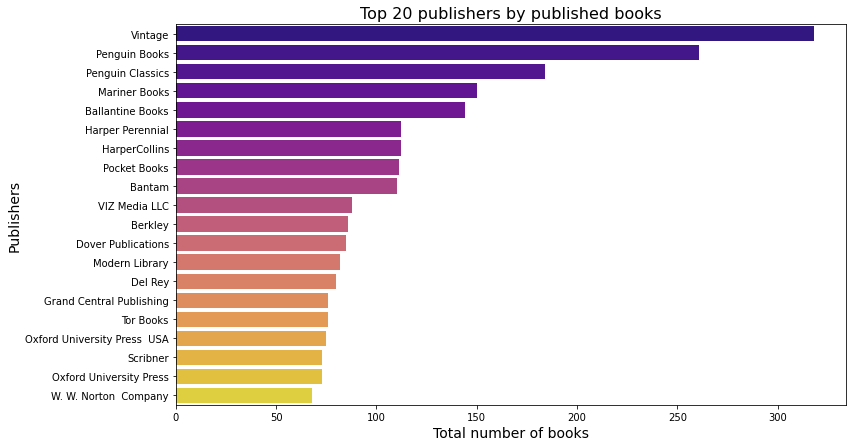

In [16]:
# Use the grouping by publisher to find publishers with the largest number of published books
most_publishers = books_publishers['title'].count().reset_index().sort_values('title',ascending=False).head(20).set_index('publisher')
plt.figure(figsize=(12,7))
ax = sns.barplot(most_publishers['title'], most_publishers.index, palette='plasma')
ax.set_title("Top 20 publishers by published books", fontsize = 16)
ax.set_xlabel("Total number of books", fontsize = 14)
ax.set_ylabel("Publishers", fontsize = 14)
plt.show()

The publisher Vintage has the most published books. The publisher data appears to be top-heavy with the top few publishers having significantly more books than any other company.

### Correlations

I will now look at correlations and relationships between variables in the data, in a couple of different ways. First we will plot average rating against total ratings. This will give an idea of whether books with more or less ratings tend to have differences in their average rating score. 

We will then plot average rating against number of pages to see whether the length of the book has a impact on its rating.

Finally, we will create a correlation matrix of all quantitative variables in the dataset to see if there are any pairs of variables that do show a strong relationship with each other.

<Figure size 720x360 with 0 Axes>

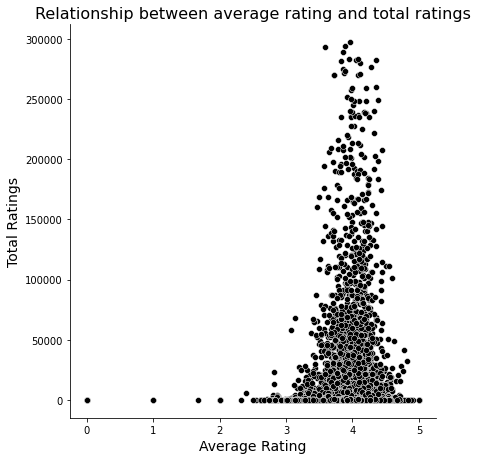

In [17]:
# Using the ratings variable created earlier that selects all books with ratings counts up to the 99th percentile, to remove outliers
plt.figure(figsize=(10,5))
ax = sns.relplot(data=books2, x="average_rating", y=ratings, color = 'black', height=6)
plt.title("Relationship between average rating and total ratings", fontsize = 16)
ax.set_axis_labels("Average Rating", "Total Ratings", fontsize = 14)
plt.show()

<Figure size 720x360 with 0 Axes>

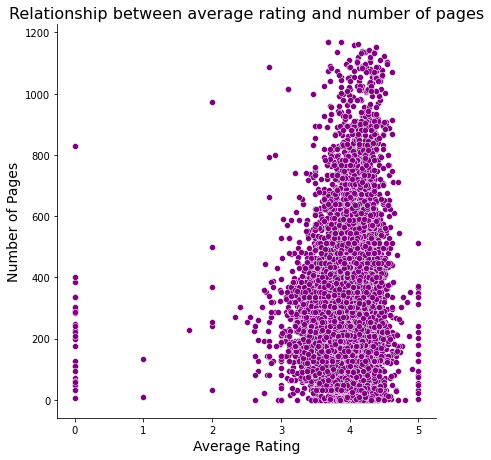

In [18]:
pages_99 = books2['num_pages'].quantile(.99)
pages = books2.num_pages.loc[books2.num_pages < pages_99]

plt.figure(figsize=(10,5))
ax = sns.relplot(data=books2, x="average_rating", y=pages, color = 'purple', height=6)
plt.title("Relationship between average rating and number of pages", fontsize = 16)
ax.set_axis_labels("Average Rating", "Number of Pages", fontsize = 14)
plt.show()

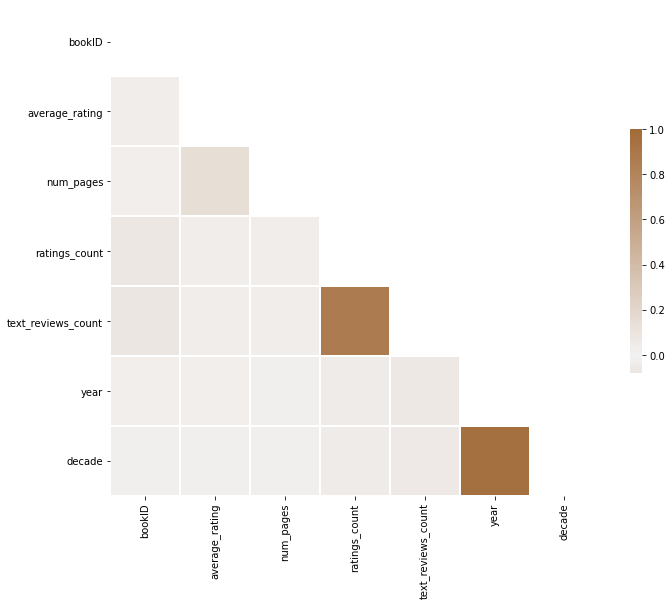

In [19]:
# Compute correlation between each 
corr = books2.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(40, 40, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.75, cbar_kws={"shrink": .5})

From the relation plots, we can determine that average rating is not significatly impacted by the total number of ratings or by the length of the book. This may be somewhat surprising, particularly in the first case, as it may be intuitive that books with more ratings were more popular and thus would have a higher average rating score. However, this does not appear to be the case.

From the correlation matrix, we see that the only meaningful variable pair that does show a strong relationship is total count of ratings and total count of text ratings. This makes sense as more users leaving numerical reviews would likely also mean more users leaving text reviews.

### WordCloud from Book Titles

I will now analyze book titles via a word cloud method. This will show the words most often used in the title across all books in the dataset.

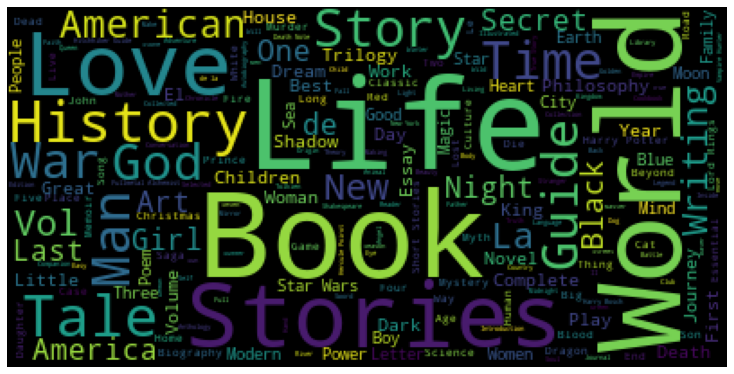

In [20]:
wordcloud2 = WordCloud().generate(' '.join(books2['title']))

plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

# Regressions

I will run two regressions on the data to see if there are any variables that have predictive power on the average rating of the book. I will first run a basic linear model and then a lasso model. 

### Linear Model

In [21]:
X = books2.drop(['average_rating','bookID', 'title',	'authors', 'language_code','publisher','year','decade','length_bins', 'publication_date'], axis = 1)
y = books2['average_rating']
lr_model = linear_model.LinearRegression()

for col in list(X):
    X[col] = X[col].astype(float)
lr_model.fit(X, y)
beta_0 = lr_model.intercept_
beta_1 = lr_model.coef_[0]
beta_2 = lr_model.coef_[1]
beta_3 = lr_model.coef_[2]
print(f"The intercept is {round(beta_0,4)}, the coefficients are {round(beta_1,4)}, {round(beta_2,7)}, {round(beta_3,7)}")
mse = metrics.mean_squared_error(y, lr_model.predict(X))
print(f"The mean squared error of the linear regression model is {round(mse,4)}")


The intercept is 3.8582, the coefficients are 0.0002, 1e-07, -2e-07
The mean squared error of the linear regression model is 0.1212


The results of the linear model show that all of the three quantitative variables (number of pages, count of ratings, and count of text ratings) had very small coefficients and were basically equal to zero. This suggests that none of the variables have prective power for average rating.

### Lasso Model

In [22]:
lasso_model = linear_model.Lasso()
lasso_model.fit(X, y)

n_test = 7500
X_train = X.iloc[:n_test, :]
X_test = X.iloc[n_test:, :]
y_train = y.iloc[:n_test]
y_test = y.iloc[n_test:]

lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)
alpha = -np.log10(lasso.alpha_)
lasso_model = linear_model.Lasso(alpha=alpha)
reg = lasso_model.fit(X, y)

lasso_coefs = pd.Series(dict(zip(list(X), lasso_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs))
coefs



,lasso
num_pages,2.235880e-04
ratings_count,1.116388e-07
text_reviews_count,-4.220255e-07


Similar to the linear model seen previously, the lasso model also shows very small coefficients for all variables and suggests none of them have predictive power on average rating of the book. Since both models showed similar results, we can be confident that none of the variables can predict a books' rating. This aligns well with the findings in the correlation matrix above that showed very minimal correlation between any of the variables.

### Analysis of models

We will now analyze our regression models by looking at their accuracy, relative to the data as well as how their performance compared with each other. 

In [23]:
# Get mse for lasso model and compare to linear model
mse2 = metrics.mean_squared_error(y, reg.predict(X))
print(f"The difference between the mean squared error in the linear regression model and the lasso model is {round(mse-mse2,6)}")

The difference between the mean squared error in the linear regression model and the lasso model is -1e-06


In [24]:
# Using method from class, compares mse of each model on the training and testing data
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

print(f"Linear Model: {fit_and_report_mses(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)}")
print(f"Lasso Model: {fit_and_report_mses(linear_model.Lasso(), X_train, X_test, y_train, y_test)}")

Linear Model: {'mse_train': 0.11614672363504044, 'mse_test': 0.13200889776427555}
Lasso Model: {'mse_train': 0.11616316185212405, 'mse_test': 0.1321002382624492}


count    1.112700e+04
mean    -2.604589e-16
std      3.482212e-01
min     -1.142905e+00
25%     -1.976234e-01
50%     -2.181719e-02
75%      1.562112e-01
max      4.042225e+00
Name: average_rating, dtype: float64


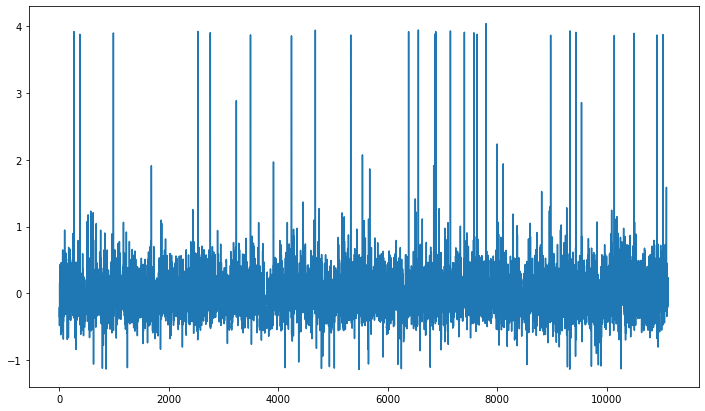

In [25]:
# Plot the performance of the lasso model based on its predictions and the actual dataset
print((reg.predict(X)-y).describe())
fig, ax = plt.subplots(figsize=(12,7))
plt.plot(reg.predict(X)-y)

# Book Suggestions Tool

In this section, I will create a tool that will suggest the best books to read, based on certain criteria. This criteria is subjective and could be changed as desired. The suggestion tool could be run again after changing the criteria values to generate new suggestions. In the case, I decided on criteria for books that are:
1. Rated above 4.5
2. From highly rated authors that have written more than one book 
3. Written in English
4. Published by a prolific publisher 
 

In [27]:
# Selected for authors who have written more than one book
authors_books = 1

# Select for english books
selected_language = 'eng'

# Select for only highly rated books
selected_rating = 4.5

# Select from the top 20 most prolific publisher
most_publishers_20 = books_publishers.bookID.count().sort_values(ascending=False).head(20)
selected_publisher = most_publishers_20.index.tolist()

# Select from the top 50 rated authors
author_multi = books_authors.filter(lambda x: len(x) > authors_books)
author_multi2 = author_multi.groupby("authors").average_rating.mean().sort_values(ascending=False).head(50)
selected_author = author_multi2.index.tolist()

# Generate book suggestions based on criteria
book_suggestions = books2[(books2.language_code == selected_language) & (books2.publisher.isin(selected_publisher)) & (books2.authors.isin(selected_author)) & (books2.average_rating >= selected_rating)]
book_suggestions[['title','authors']]


,title,authors
21,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien
285,Fullmetal Alchemist Vol. 9 (Fullmetal Alchemi...,Hiromu Arakawa/Akira Watanabe
286,Fullmetal Alchemist Vol. 3 (Fullmetal Alchemi...,Hiromu Arakawa/Akira Watanabe
287,Fullmetal Alchemist Vol. 8 (Fullmetal Alchemi...,Hiromu Arakawa/Akira Watanabe
288,Fullmetal Alchemist Vol. 1 (Fullmetal Alchemi...,Hiromu Arakawa/Akira Watanabe
289,Fullmetal Alchemist Vol. 4 (Fullmetal Alchemi...,Hiromu Arakawa/Akira Watanabe
291,Fullmetal Alchemist Vol. 2 (Fullmetal Alchemi...,Hiromu Arakawa/Akira Watanabe
2528,Fullmetal Alchemist Vol. 10,Hiromu Arakawa/Akira Watanabe
2529,Fullmetal Alchemist Vol. 5 (Fullmetal Alchemi...,Hiromu Arakawa/Akira Watanabe
4245,The Complete Maus,Art Spiegelman


We see from the suggestion tool that the books meeting this criteria are The Hobbit and Lord of the Rings boxed set, The Complete Maus, The Diary of Virginia Woolf, and many volumes in the Fullmetal Alchemist series. 